In [7]:
# Import necessary libraries
import cv2
import numpy as np
import os
from sklearn.cluster import MiniBatchKMeans
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.datasets import fetch_openml
from typing import List, Tuple, Dict, Optional
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm  # Import notebook version of tqdm for progress bars
import pickle 
import time
import seaborn as sns
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

print("All required libraries have been imported.")
print(f"OpenCV version: {cv2.__version__}")
print(f"NumPy version: {np.__version__}")
from sklearn import __version__ as sklearn_version

print(f"Scikit-learn version: {sklearn_version}")


All required libraries have been imported.
OpenCV version: 4.11.0
NumPy version: 2.0.2
Scikit-learn version: 1.5.2


### 1. 配置参数
我们将定义一个配置类来管理实验中的各个参数。许多这些参数后续可以被超参数搜索过程覆盖。

In [8]:
class ConfigCIFAR10:

    IMAGE_SIZE = (32, 32)
    TARGET_IMAGE_SIZE = (64, 64)  # Target image size
    N_CLASSES = 10
    CLASS_NAMES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


    DETECTOR_TYPE = 'SIFT'  # Options: 'SIFT', 'ORB'
    FEATURE_LIMIT_PER_IMAGE = 100

    VOCAB_SIZE = 500
    VOCAB_SAMPLE_LIMIT = 5000

    SVM_KERNEL = 'rbf'  # SVM kernel function
    SVM_C = 1.0
    SVM_GAMMA = 'scale'


    TEST_SIZE = 0.2
    RANDOM_STATE = 42  # Random seed

    PLOT_ROC_AUC = True

    PERFORM_GRID_SEARCH = True

    GRID_SEARCH_CV_FOLDS = 3

    MODEL_DIR = "cifar10_models/"
    VOCAB_FILE = os.path.join(MODEL_DIR, f"vocab_k{VOCAB_SIZE}_{DETECTOR_TYPE}.pkl")
    SVM_MODEL_FILE = os.path.join(MODEL_DIR, f"svm_model_{DETECTOR_TYPE}_vocab{VOCAB_SIZE}.pkl")

    # 确保模型目录存在
    if not os.path.exists(MODEL_DIR):
        os.makedirs(MODEL_DIR)


config = ConfigCIFAR10()
print(f"the parameters has been set. the vocabulary size is {config.VOCAB_SIZE}, the detector is {config.DETECTOR_TYPE}")
print(f"the model will be saved in {config.MODEL_DIR}")

the parameters has been set. the vocabulary size is 500, the detector is SIFT
the model will be saved in cifar10_models/



### 2. 加载 CIFAR-10 数据集
我们将使用
`sklearn.datasets.fetch_openml`
来加载
CIFAR - 10。数据会以
NumPy
数组的形式返回。
图像需要从
RGB
转换为灰度图，因为
SIFT
等传统特征检测器通常在灰度图上工作。

Starting to load CIFAR-10 dataset (this may take several minutes)...
CIFAR-10 dataset loaded.
Original image data shape: (20000, 32, 32, 3)
Label data shape: (20000,)
Converting images to grayscale...


Grayscale conversion: 100%|██████████| 20000/20000 [00:00<00:00, 133638.06it/s]


Grayscale image data shape: (20000, 32, 32)
Resizing grayscale images from (32, 32) to (64, 64)...


Resolution adjustment: 100%|██████████| 20000/20000 [00:00<00:00, 174907.69it/s]


Resized image data shape: (20000, 64, 64)
Number of training images: 16000, Number of test images: 4000
Number of training labels: 16000, Number of test labels: 4000


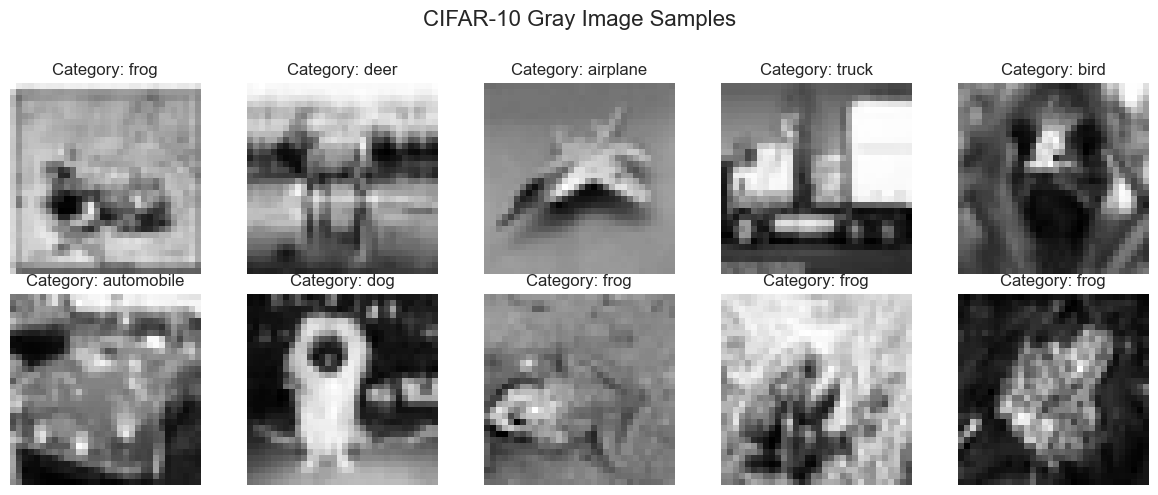


Data loading and initial preprocessing complete. Class names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training set samples per class: {'airplane': np.int64(1604), 'automobile': np.int64(1579), 'bird': np.int64(1625), 'cat': np.int64(1613), 'deer': np.int64(1599), 'dog': np.int64(1550), 'frog': np.int64(1624), 'horse': np.int64(1601), 'ship': np.int64(1620), 'truck': np.int64(1585)}
Test set samples per class: {'airplane': np.int64(401), 'automobile': np.int64(395), 'bird': np.int64(407), 'cat': np.int64(403), 'deer': np.int64(400), 'dog': np.int64(387), 'frog': np.int64(406), 'horse': np.int64(400), 'ship': np.int64(405), 'truck': np.int64(396)}


In [9]:
from typing import Tuple, List
import numpy as np
import cv2
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

def load_cifar10_data() -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, List[str]]:
    print("Starting to load CIFAR-10 dataset (this may take several minutes)...")
    cifar10 = fetch_openml(data_id=40926, as_frame=False, parser='auto')
    print("CIFAR-10 dataset loaded.")

    X = cifar10.data.astype('uint8')
    y = cifar10.target.astype('uint8')
    class_names = config.CLASS_NAMES

    if X.shape[1] == 3072:
        X = X.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    elif X.shape[1] == 3 and X.shape[2] == 32 and X.shape[3] == 32:
        X = X.transpose(0, 2, 3, 1)
    elif X.shape[1] == 32 and X.shape[2] == 32 and X.shape[3] == 3:
        pass
    else:
        raise ValueError(f"Unknown CIFAR-10 data shape: {X.shape}")

    print(f"Original image data shape: {X.shape}")
    print(f"Label data shape: {y.shape}")

    # Convert RGB images to grayscale

    print("Converting images to grayscale...")
    X_gray = np.array([
        cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        for img in tqdm(X, desc="Grayscale conversion")
    ])
    print(f"Grayscale image data shape: {X_gray.shape}")

    # Resize images if needed
    if config.TARGET_IMAGE_SIZE != config.IMAGE_SIZE:
        print(f"Resizing grayscale images from {config.IMAGE_SIZE} to {config.TARGET_IMAGE_SIZE}...")
        X_processed = np.array([
            cv2.resize(img, config.TARGET_IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)
            for img in tqdm(X_gray, desc="Resolution adjustment")
        ])
        print(f"Resized image data shape: {X_processed.shape}")
    else:
        X_processed = X_gray
        print("Target image size matches original; no resizing performed.")


    X_train, X_test, y_train, y_test = train_test_split(
        X_gray, y,
        test_size=config.TEST_SIZE,
        random_state=config.RANDOM_STATE,
        stratify=y
    )
    print(f"Number of training images: {X_train.shape[0]}, Number of test images: {X_test.shape[0]}")
    print(f"Number of training labels: {y_train.shape[0]}, Number of test labels: {y_test.shape[0]}")

    return X_train, X_test, y_train, y_test, class_names

# Execute data loading
X_train_raw, X_test_raw, y_train, y_test, class_names = load_cifar10_data()



def plot_cifar_samples(images, labels, class_names_list, num_samples=10):
    plt.figure(figsize=(12, 5))
    for i in range(num_samples):
        plt.subplot(2, num_samples // 2, i + 1)
        plt.imshow(images[i], cmap='gray' if images[i].ndim == 2 else None)
        plt.title(f"Category: {class_names_list[labels[i]]}")
        plt.axis('off')
    plt.suptitle("CIFAR-10 Gray Image Samples", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

plot_cifar_samples(X_train_raw, y_train, class_names, num_samples=10)

print(f"\nData loading and initial preprocessing complete. Class names: {class_names}")
unique_labels, counts = np.unique(y_train, return_counts=True)
print(f"Training set samples per class: {dict(zip([class_names[i] for i in unique_labels], counts))}")
unique_labels_test, counts_test = np.unique(y_test, return_counts=True)
print(f"Test set samples per class: {dict(zip([class_names[i] for i in unique_labels_test], counts_test))}")

SIFT detector created successfully.
Sampling 5000 images from the training set for vocabulary construction.
Starting feature extraction for vocabulary construction (5000 images)...
Extracting features from 5000 images using SIFT...


Feature extraction: 100%|██████████| 5000/5000 [00:01<00:00, 2805.81it/s]


Feature extraction complete. Extracted 65189 descriptors from 4991 images.
Average descriptors per valid image: 13.06
Number of descriptor arrays: 4991


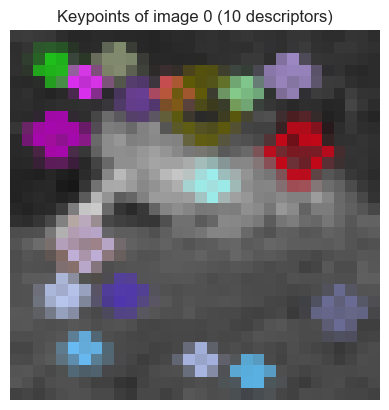

Total descriptors for vocabulary: 65189, Dimension: 128


In [10]:
def create_detector(detector_type: str):
    """
    Create a feature detector/descriptor based on the specified type.
    Note: SIFT may require opencv-contrib-python in some OpenCV versions.
          Make sure it is installed: pip install opencv-python opencv-contrib-python
    """
    if detector_type == 'SIFT':
        # SIFT may perform poorly on small images (32x32), parameters may need adjustment
        try:
            return cv2.SIFT_create(
                nfeatures=config.FEATURE_LIMIT_PER_IMAGE,
                contrastThreshold=0.04,
                edgeThreshold=10
            )
        except AttributeError:
            print("Error: cv2.SIFT_create() is not available. Make sure opencv-contrib-python is installed and compatible.")
            print("Try installing: pip install opencv-contrib-python")
            raise
    elif detector_type == 'ORB':
        # nfeatures: maximum number of features
        # scaleFactor: pyramid decimation ratio (>1), used to build the image pyramid
        # nlevels: number of pyramid levels
        return cv2.ORB_create(
            nfeatures=config.FEATURE_LIMIT_PER_IMAGE,
            scoreType=cv2.ORB_FAST_SCORE
        )
    else:
        raise ValueError(f"Unsupported detector type: {detector_type}")


def extract_features(images: np.ndarray, detector) -> Tuple[List[np.ndarray], List[int]]:

    all_descriptors = []
    descriptors_per_image_count = []
    print(f"Extracting features from {len(images)} images using {config.DETECTOR_TYPE}...")

    for img in tqdm(images, desc="Feature extraction"):
        # Ensure image is uint8
        if img.dtype != np.uint8:
            img_processed = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')
        else:
            img_processed = img

        keypoints, descriptors = detector.detectAndCompute(img_processed, None)

        if descriptors is not None:


            if len(descriptors) > 0:
                all_descriptors.append(descriptors)
                descriptors_per_image_count.append(len(descriptors))
            else:

                descriptors_per_image_count.append(0)
        else:

            descriptors_per_image_count.append(0)

    if not all_descriptors:
        print(f"Warning: No descriptors extracted from any image. Check detector type '{config.DETECTOR_TYPE}' and image quality/size.")
        return [], []

    total_images_with_desc = sum(1 for count in descriptors_per_image_count if count > 0)
    total_descriptors = sum(descriptors_per_image_count)
    print(f"Feature extraction complete. Extracted {total_descriptors} descriptors from {total_images_with_desc} images.")
    avg_descriptors = (
        np.mean([c for c in descriptors_per_image_count if c > 0])
        if any(c > 0 for c in descriptors_per_image_count)
        else 0
    )
    print(f"Average descriptors per valid image: {avg_descriptors:.2f}")
    print(f"Number of descriptor arrays: {len(all_descriptors)}")

    # Visualize keypoints on the first image that has descriptors
    for i, desc in enumerate(all_descriptors):
        if desc is not None and len(desc) > 0:
            img_with_keypoints = cv2.drawKeypoints(
                images[i],
                keypoints,
                None,
                flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
            )
            plt.imshow(img_with_keypoints, cmap='gray')
            plt.title(f"Keypoints of image {i} ({len(desc)} descriptors)")
            plt.axis('off')
            plt.show()
            break  # Show only the first example

    return all_descriptors, descriptors_per_image_count


# Initialize the detector
try:
    detector = create_detector(config.DETECTOR_TYPE)
    print(f"{config.DETECTOR_TYPE} detector created successfully.")


    num_vocab_samples = min(config.VOCAB_SAMPLE_LIMIT, len(X_train_raw))
    if num_vocab_samples < len(X_train_raw):
        print(f"Sampling {num_vocab_samples} images from the training set for vocabulary construction.")
        sample_indices = np.random.choice(len(X_train_raw), num_vocab_samples, replace=False)
        X_vocab_samples = X_train_raw[sample_indices]
    else:
        print("Using all training images for vocabulary construction.")
        X_vocab_samples = X_train_raw

    print(f"Starting feature extraction for vocabulary construction ({len(X_vocab_samples)} images)...")
    vocab_descriptors_list, _ = extract_features(X_vocab_samples, detector)

    if not vocab_descriptors_list:
        raise ValueError("No descriptors extracted for vocabulary construction. Pipeline cannot continue. Try a different detector or check your images.")

    # Stack all descriptors into one large NumPy array for K-Means
    all_descriptors_for_vocab = np.vstack(
        [desc for desc in vocab_descriptors_list if desc is not None and len(desc) > 0]
    )
    print(f"Total descriptors for vocabulary: {all_descriptors_for_vocab.shape[0]}, Dimension: {all_descriptors_for_vocab.shape[1]}")

except Exception as e:
    print(f"Error during feature extraction stage: {e}")
    all_descriptors_for_vocab = None  # Ensure variable exists to avoid downstream errors

### 4. 构建视觉词汇表 (BoVW)
使用
K - Means
算法对提取出的特征描述符进行聚类，聚类中心即为视觉词汇。
我们将使用
`MiniBatchKMeans`
以加速处理。

In [11]:
def build_vocabulary(descriptors_matrix: np.ndarray, vocab_size: int, random_state: int) -> MiniBatchKMeans:

    if descriptors_matrix is None or descriptors_matrix.shape[0] == 0:
        raise ValueError("Descriptor matrix is empty; cannot build vocabulary.")
    if descriptors_matrix.shape[0] < vocab_size:
        print(f"Warning: number of descriptors ({descriptors_matrix.shape[0]}) is less than requested vocabulary size ({vocab_size}).")
        print(f"Setting KMeans n_clusters to {descriptors_matrix.shape[0]}.")
        actual_vocab_size = descriptors_matrix.shape[0]
    else:
        actual_vocab_size = vocab_size

    print(f"Starting to build visual vocabulary of size {actual_vocab_size} using MiniBatchKMeans...")

    kmeans = MiniBatchKMeans(
        n_clusters=actual_vocab_size,
        random_state=random_state,
        batch_size=256 * 3,
        n_init='auto',
        max_iter=100,
        verbose=0
    )

    start_time = time.time()
    kmeans.fit(descriptors_matrix)
    end_time = time.time()
    print(f"Visual vocabulary built. Time elapsed: {end_time - start_time:.2f} seconds.")
    print(f"Vocabulary center shape (K, D): {kmeans.cluster_centers_.shape}")
    return kmeans


# Build or load vocabulary
vocabulary = None
if all_descriptors_for_vocab is not None and all_descriptors_for_vocab.shape[0] > 0:
    try:
        if os.path.exists(config.VOCAB_FILE):
            print(f"Loading precomputed vocabulary from file: {config.VOCAB_FILE}")
            with open(config.VOCAB_FILE, 'rb') as f:
                vocabulary = pickle.load(f)
            if not hasattr(vocabulary, 'n_clusters') or vocabulary.n_clusters != config.VOCAB_SIZE:
                print(
                    f"Warning: loaded vocabulary size ({getattr(vocabulary, 'n_clusters', 'unknown')}) "
                    f"does not match config ({config.VOCAB_SIZE}). Rebuilding.")
                vocabulary = None  # force rebuild
            else:
                print("Vocabulary loaded successfully.")

        if vocabulary is None:  # file missing or size mismatch
            print("Building a new visual vocabulary...")
            vocabulary = build_vocabulary(all_descriptors_for_vocab, config.VOCAB_SIZE, config.RANDOM_STATE)
            print(f"Saving vocabulary to: {config.VOCAB_FILE}")
            with open(config.VOCAB_FILE, 'wb') as f:
                pickle.dump(vocabulary, f)
            print("Vocabulary saved.")

    except ValueError as ve:
        print(f"Error while building vocabulary: {ve}")
        print("Pipeline may not continue.")
    except Exception as e:
        print(f"Unknown error while building or loading vocabulary: {e}")
else:
    print("Error: no descriptors available for vocabulary construction. Please check the feature extraction step.")

if vocabulary:
    print(f"Final vocabulary size (K): {vocabulary.n_clusters}")
else:
    print("Failed to build or load vocabulary.")

从文件加载预先计算的词汇表: cifar10_models/vocab_k500_SIFT.pkl
词汇表加载成功。
最终词汇表大小 (K): 500


### 5. 将图像转换为 BoVW 特征向量
现在我们有了视觉词汇表，可以将每张图像表示为一个基于其包含的“视觉词汇”频率的直方图（向量）。

In [12]:
import numpy as np
from sklearn import svm
from tqdm import tqdm

def descriptors_to_bovw_histograms(
        image_descriptors_list: List[np.ndarray],
        vocabulary: MiniBatchKMeans,
        descriptors_counts: List[int]
) -> np.ndarray:

    vocab_size = vocabulary.n_clusters
    num_images = len(descriptors_counts)

    bovw_histograms = np.zeros((num_images, vocab_size), dtype=np.float32)

    print(f"Starting conversion of {len(image_descriptors_list)} descriptor sets (for {num_images} images) to BoVW histograms...")

    desc_list_idx = 0
    for i in tqdm(range(num_images), desc="Images → BoVW vectors"):
        if descriptors_counts[i] > 0:  # If the current image has descriptors
            if desc_list_idx < len(image_descriptors_list) and \
               image_descriptors_list[desc_list_idx] is not None and \
               image_descriptors_list[desc_list_idx].shape[0] > 0:

                descriptors = image_descriptors_list[desc_list_idx]
                visual_words = vocabulary.predict(descriptors)

                # Compute the histogram of visual words
                hist, _ = np.histogram(visual_words, bins=np.arange(vocab_size + 1), density=False)

                #  L1 normalize the histogram
                # hist = hist.astype(np.float32) / np.sum(hist)  # L1 normalization
                # hist = hist.astype(np.float32) / np.linalg.norm(hist)  # L2 normalization
                # if np.sum(hist) > 0:
                #     hist = hist.astype(np.float32) / np.sum(hist)

                bovw_histograms[i, :] = hist
                desc_list_idx += 1
            else:

                pass

    if desc_list_idx != len(image_descriptors_list):
        print(f"Warning: number of descriptor sets processed ({desc_list_idx}) does not match the expected ({len(image_descriptors_list)}).")

    print("BoVW feature vectors construction complete.")
    print(f"BoVW feature matrix shape: {bovw_histograms.shape}")
    return bovw_histograms



if vocabulary is not None:

    print("Extracting features from training set to build BoVW vectors...")
    train_descriptors_list, train_desc_counts = extract_features(X_train_raw, detector)
    if not train_descriptors_list and sum(train_desc_counts) == 0:
        print("Error: No feature descriptors extracted from the training set. Cannot create BoVW vectors.")
        X_train_bovw = np.array([])
    else:

        X_train_bovw = descriptors_to_bovw_histograms(train_descriptors_list, vocabulary, train_desc_counts)
        print(f"Training set BoVW feature shape: {X_train_bovw.shape}")

    print("\nExtracting features from test set to build BoVW vectors...")
    test_descriptors_list, test_desc_counts = extract_features(X_test_raw, detector)

    if not test_descriptors_list and sum(test_desc_counts) == 0:
        print("Error: No feature descriptors extracted from the test set. Cannot create BoVW vectors.")
        X_test_bovw = np.array([])
    else:
        X_test_bovw = descriptors_to_bovw_histograms(test_descriptors_list, vocabulary, test_desc_counts)
        print(f"Test set BoVW feature shape: {X_test_bovw.shape}")

    # Verify that shapes match expectations
    if X_train_bovw.shape[0] != len(X_train_raw) or \
       (len(X_test_raw) > 0 and X_test_bovw.shape[0] != len(X_test_raw)):
        print("Warning: Number of BoVW vectors does not match number of original images! Please check the pipeline.")
        print(f"X_train_raw: {len(X_train_raw)}, X_train_bovw: {X_train_bovw.shape[0]}")
        if len(X_test_raw) > 0:
            print(f"X_test_raw: {len(X_test_raw)}, X_test_bovw: {X_test_bovw.shape[0]}")

    if X_train_bovw.shape[0] > 0:
        print(f"\nExample BoVW histogram for one training image (first 50 words):\n{X_train_bovw[0, :50]}")
        print(f"Sum of histogram bins: {np.sum(X_train_bovw[0, :])} (equals number of keypoints when not normalized)")

else:
    print("Error: Vocabulary is not defined. Cannot convert images to BoVW feature vectors. Please rerun previous steps.")
    X_train_bovw = np.array([])
    X_test_bovw = np.array([])

为训练集提取特征以构建BoVW向量...
Extracting features from 16000 images using SIFT...


Feature extraction:  46%|████▌     | 7368/16000 [00:02<00:03, 2729.31it/s]


KeyboardInterrupt: 

In [ ]:
def plot_roc_auc_multiclass(y_true, y_score, class_names, figsize=(10, 8)):

    n_classes = len(class_names)
    y_true_binarized = label_binarize(y_true, classes=np.arange(n_classes))
    if y_score.shape[1] != n_classes:
        raise ValueError(
            f"Number of columns in y_score ({y_score.shape[1]}) "
            f"must equal number of classes ({n_classes})"
        )

    plt.figure(figsize=figsize)


    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(
            fpr,
            tpr,
            lw=2,
            label=f'Class {class_names[i]} (AUC = {roc_auc:.2f})'
        )

    fpr_micro, tpr_micro, _ = roc_curve(y_true_binarized.ravel(), y_score.ravel())
    roc_auc_micro = auc(fpr_micro, tpr_micro)
    plt.plot(
        fpr_micro,
        tpr_micro,
        label=f'Micro-average ROC (AUC = {roc_auc_micro:.2f})',
        color='deeppink',
        linestyle=':',
        linewidth=4
    )

    all_fpr = np.unique(
        np.concatenate([
            roc_curve(y_true_binarized[:, i], y_score[:, i])[0]
            for i in range(n_classes)
        ])
    )

    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        fpr_i, tpr_i, _ = roc_curve(y_true_binarized[:, i], y_score[:, i])
        mean_tpr += np.interp(all_fpr, fpr_i, tpr_i)
    # Average and compute AUC
    mean_tpr /= n_classes
    roc_auc_macro = auc(all_fpr, mean_tpr)
    plt.plot(
        all_fpr,
        mean_tpr,
        label=f'Macro-average ROC (AUC = {roc_auc_macro:.2f})',
        color='navy',
        linestyle=':',
        linewidth=4
    )


    plt.plot([0, 1], [0, 1], 'k--', lw=2)

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(
        f'Multiclass ROC Curve '
        f'(Using {config.SVM_KERNEL} Kernel SVM, C={config.SVM_C}, gamma={config.SVM_GAMMA})'
    )
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### 6. 训练和评估分类器 (SVM)
利用上一步生成的
BoVW
特征向量，我们现在可以训练一个分类器（例如
SVM）来进行图像分类，并在测试集上评估其性能。

In [ ]:
import numpy as np
from sklearn import svm
import time
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from typing import List
from sklearn.cluster import MiniBatchKMeans

def train_svm_classifier(X_train_features: np.ndarray, y_train_labels: np.ndarray, random_state: int,
                         C_value: float = 1.0, gamma_value: str = 'scale') -> svm.SVC:

    if X_train_features.shape[0] == 0:
        raise ValueError("Training features are empty; cannot train SVM classifier.")
    if len(np.unique(y_train_labels)) < 2:
        raise ValueError(f"Fewer than 2 classes in training labels ({np.unique(y_train_labels)}); cannot train classifier.")

    print(f"Starting SVM classifier training... C={C_value}, gamma={gamma_value}")
    print(f"Training data shape: {X_train_features.shape}, Label shape: {y_train_labels.shape}")

    classifier = svm.SVC(
        kernel=config.SVM_KERNEL,
        C=C_value,
        gamma=gamma_value,
        random_state=random_state,
        probability=True if config.PLOT_ROC_AUC else False
    )

    start_time = time.time()
    classifier.fit(X_train_features, y_train_labels)
    end_time = time.time()

    print(f"SVM classifier training complete. Time elapsed: {end_time - start_time:.2f} seconds.")
    return classifier


def evaluate_classifier(classifier, X_test_features: np.ndarray, y_test_labels: np.ndarray,
                        class_names_list: List[str]):  # , scaler=None):
    if X_test_features.shape[0] == 0:
        print("Test features are empty; cannot evaluate.")
        return

    # if scaler:
    #     X_test_features = scaler.transform(X_test_features)

    print("\nEvaluating classifier on test set...")
    y_pred = classifier.predict(X_test_features)

    accuracy = accuracy_score(y_test_labels, y_pred)
    print(f"Accuracy: {accuracy:.4f}")

    print("\nClassification Report:")
    report = classification_report(
        y_test_labels,
        y_pred,
        target_names=class_names_list,
        zero_division=0
    )
    print(report)

    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test_labels, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names_list,
        yticklabels=class_names_list
    )
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    if config.PLOT_ROC_AUC and hasattr(classifier, "predict_proba"):
        try:
            y_proba = classifier.predict_proba(X_test_features)
            plot_roc_auc_multiclass(y_test_labels, y_proba, class_names_list)
        except Exception as e_roc:
            print(f"Error plotting ROC AUC curve: {e_roc}")



if 'X_train_bovw' in globals() and 'X_test_bovw' in globals() and \
        X_train_bovw.shape[0] > 0 and y_train.shape[0] > 0:

    # Ensure the number of training features matches the number of labels
    if X_train_bovw.shape[0] != y_train.shape[0]:
        print(f"Error: Number of training BoVW features ({X_train_bovw.shape[0]}) "
              f"does not match number of training labels ({y_train.shape[0]})!")
    else:
        svm_classifier = None
        try:
            # Train the SVM
            svm_classifier = train_svm_classifier(
                X_train_bovw,
                y_train,
                config.RANDOM_STATE,
                config.SVM_C,
                config.SVM_GAMMA
            )


            if X_test_bovw.shape[0] > 0 and y_test.shape[0] > 0:
                if X_test_bovw.shape[0] != y_test.shape[0]:
                    print(f"Warning: Number of test BoVW features ({X_test_bovw.shape[0]}) "
                          f"does not match number of test labels ({y_test.shape[0]})! Skipping evaluation.")
                else:
                    evaluate_classifier(svm_classifier, X_test_bovw, y_test, class_names)
            elif X_test_bovw.shape[0] == 0 and y_test.shape[0] > 0:
                print("Test set BoVW features are empty; cannot evaluate.")
            else:
                print("Test set is empty or BoVW features were not generated; skipping evaluation.")

        except ValueError as ve:
            print(f"Value error during SVM training or evaluation: {ve}")
        except Exception as e:
            print(f"Unexpected error during SVM training or evaluation: {e}")
else:
    print("Error: BoVW features were not generated successfully or training data is empty. Cannot train or evaluate SVM classifier.")
    print(f"X_train_bovw exists: {'X_train_bovw' in globals()}, count: {X_train_bovw.shape[0] if 'X_train_bovw' in globals() else 'N/A'}")
    print(f"y_train exists: {'y_train' in globals()}, count: {y_train.shape[0] if 'y_train' in globals() else 'N/A'}")

### 7. (可选) 使用其他分类器或进行参数调优
可以尝试其他分类器，例如随机森林、梯度提升树等，或者对当前SVM进行参数调优（例如使用
GridSearchCV）。
还可以进行错误分析，查看哪些类别的图像最容易被混淆。

In [ ]:
from sklearn.model_selection import GridSearchCV

def tune_svm_parameters(X_train_features: np.ndarray, y_train_labels: np.ndarray, random_state: int) -> GridSearchCV:

    if X_train_features.shape[0] == 0:
        raise ValueError("Training features are empty; cannot perform parameter tuning.")
    if len(np.unique(y_train_labels)) < 2:
        raise ValueError("Fewer than 2 classes in training labels; cannot perform parameter tuning.")

    print("Starting SVM parameter tuning (GridSearchCV)...")

    if config.SVM_KERNEL == 'linear':
        param_grid = {
            'C': [1,10,15]
        }
    else:  # e.g. 'rbf'
        param_grid = {
            'C': [1],
            'gamma': [0.01, 0.1, 1, 'scale', 'auto']
        }

    base_svm = svm.SVC(
        kernel=config.SVM_KERNEL,
        random_state=random_state,
        probability=config.PLOT_ROC_AUC
    )

    grid_search = GridSearchCV(
        estimator=base_svm,
        param_grid=param_grid,
        cv=config.GRID_SEARCH_CV_FOLDS,  # 3,5
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    print(f"Parameter grid: {param_grid}")
    print(f"Performing search with {config.GRID_SEARCH_CV_FOLDS}-fold cross-validation...")

    start_time = time.time()
    grid_search.fit(X_train_features, y_train_labels)
    end_time = time.time()

    print(f"GridSearchCV complete. Time elapsed: {end_time - start_time:.2f} seconds.")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validation accuracy with best parameters: {grid_search.best_score_:.4f}")

    return grid_search


if config.PERFORM_GRID_SEARCH and 'X_train_bovw' in globals() and X_train_bovw.shape[0] > 0 and y_train.shape[0] > 0:
    if X_train_bovw.shape[0] != y_train.shape[0]:
        print(
            f"Error: Number of training BoVW features ({X_train_bovw.shape[0]}) does not match number of training labels ({y_train.shape[0]}); cannot perform parameter tuning.")
    else:
        try:
            print("\n--- SVM Parameter Tuning ---")
            grid_search_cv = tune_svm_parameters(X_train_bovw, y_train, config.RANDOM_STATE)

            best_svm_classifier = grid_search_cv.best_estimator_
            print("\n--- Evaluating best SVM model from GridSearchCV ---")

            if X_test_bovw.shape[0] > 0 and y_test.shape[0] > 0:
                if X_test_bovw.shape[0] != y_test.shape[0]:
                    print(
                        f"Warning: Number of test BoVW features ({X_test_bovw.shape[0]}) does not match number of test labels ({y_test.shape[0]}); skipping evaluation.")
                else:
                    evaluate_classifier(best_svm_classifier, X_test_bovw, y_test, class_names)
            elif X_test_bovw.shape[0] == 0 and y_test.shape[0] > 0:
                print("Test set BoVW features are empty; cannot evaluate tuned model.")
            else:
                print("Test set is empty or BoVW features not generated; skipping tuned model evaluation.")

            # model_filename = f"best_svm_model_{config.DETECTOR_TYPE}_vocab{config.VOCAB_SIZE}.pkl"
            # print(f"Saving best SVM model to: {model_filename}")
            # with open(model_filename, 'wb') as f:
            #     pickle.dump(best_svm_classifier, f)

        except ValueError as ve:
            print(f"Value error during SVM parameter tuning: {ve}")
        except Exception as e:
            print(f"Unexpected error during SVM parameter tuning: {e}")
elif not config.PERFORM_GRID_SEARCH:
    print("\nParameter tuning is disabled in configuration (PERFORM_GRID_SEARCH=False). Skipping this step.")
else:
    print("\nError: BoVW features not generated successfully or training data is empty; cannot perform SVM parameter tuning.")

### 8. 总结与展望
在这个
Notebook
中，我们实现了一个经典的基于
BoVW
和
SVM
的图像分类流程。
主要的步骤包括：
1. ** 加载和预处理数据 **：调整图像大小，转换为灰度图。
2. ** 配置参数 **：设置关键参数如特征检测器类型、词汇表大小等。
3. ** 特征提取 **：使用选择的检测器（如SIFT, ORB, KAZE, AKAZE）提取局部图像特征。
4. ** 构建视觉词汇表 **：使用
K - Means（MiniBatchKMeans）对从训练子集中提取的特征进行聚类，形成视觉词汇。
5. ** 图像表示 **：将每张图像转换为其视觉词汇的直方图（BoVW
特征向量）。
6. ** 分类器训练与评估 **：使用
BoVW
特征训练
SVM
分类器，并在测试集上评估其性能。
7. ** (可选)
参数调优 **：使用
GridSearchCV
寻找
SVM
的最优超参数。

** 可能的改进方向和进一步工作： **
* ** 深度特征 **：尝试使用预训练的深度学习模型（如
ResNet, VGG）提取的特征，通常它们能提供更强大的图像表示能力。
* ** 更高级的池化方法 **：除了标准的
BoVW
词袋模型，可以研究
VLAD, Fisher
Vector
等更高级的编码和池化方法。
* ** 特征选择 / 降维 **：在
BoVW
特征上应用
PCA
或其他特征选择技术，看是否能提高性能或降低计算复杂度。
* ** 不同分类器 **：实验其他分类器，如随机森林、梯度提升机、或简单的神经网络。
* ** 处理类别不平衡 **：如果数据集中存在类别不平衡，可以采用过采样、欠采样或代价敏感学习等方法。
* ** 结合RGBD信息 **：目前我们只使用了RGB信息（转换为灰度）。如果数据集包含深度（D）信息，可以探索如何有效地将其融入特征提取或分类阶段。例如，将深度图作为额外的通道，或者从中提取HHA编码等。
* ** 更全面的错误分析 **：详细分析分类错误的样本，理解模型在哪些情况下表现不佳。
* ** 数据增强 **：对训练图像应用数据增强技术（旋转、缩放、翻转等）可以增加训练样本的多样性，可能提高模型的泛化能力。